In [1]:
pip install numpy pandas matplotlib pillow opencv-python scikit-learn tensorflow

In [2]:
pip install tensorflow_datasets

In [3]:
import tensorflow_datasets as tfds

(train_data, test_data), info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.66BIK2_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.66BIK2_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101

In [4]:
for image, label in train_data.take(1):
    print(f"Изображение: {image.shape}, Метка: {label}")

Изображение: (512, 512, 3), Метка: 65


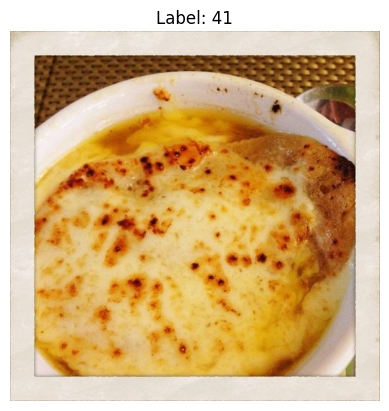

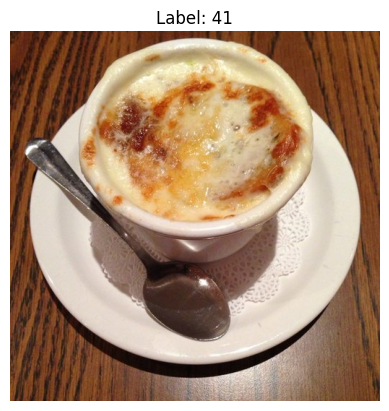

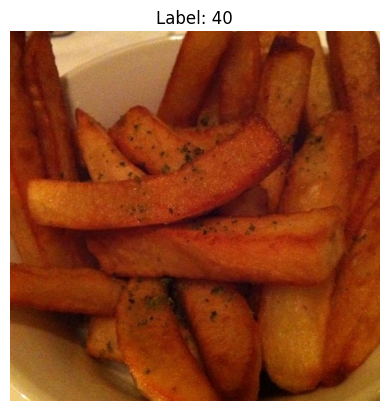

In [5]:
import matplotlib.pyplot as plt

def show_image(image, label):
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

for image, label in train_data.take(3):
    show_image(image.numpy(), label.numpy())

In [6]:
class_names = info.features['label'].names
print(f"Количество категорий: {len(class_names)}")
print(f"Категории (первые 10): {class_names[:10]}")

Количество категорий: 101
Категории (первые 10): ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [7]:
import tensorflow as tf
print("GPU доступен:", tf.config.list_physical_devices('GPU'))

GPU доступен: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
def preprocess_image(image, label, image_size=(224, 224)):
    image = tf.image.resize(image, image_size)
    image = image / 127.5 - 1.0
    return image, label

In [9]:
train_data = train_data.map(preprocess_image)
test_data = test_data.map(preprocess_image)

In [10]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [11]:
batch_size = 32
shuffle_buffer = 1000

train_data = train_data.shuffle(shuffle_buffer).map(augment_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
for image_batch, label_batch in train_data.take(1):
    print(f"Размер батча изображений: {image_batch.shape}")
    print(f"Размер батча меток: {label_batch.shape}")

Размер батча изображений: (32, 224, 224, 3)
Размер батча меток: (32,)


In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(101, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,387,365 (9.11 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 305s 122ms/step - accuracy: 0.1947 - loss: 3.6935 - val_accuracy: 0.5061 - val_loss: 2.1055
Epoch 2/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 257s 108ms/step - accuracy: 0.4906 - loss: 2.1461 - val_accuracy: 0.5663 - val_loss: 1.7464
Epoch 3/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 223s 94ms/step - accuracy: 0.5447 - loss: 1.8557 - val_accuracy: 0.5916 - val_loss: 1.6085
Epoch 4/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 265s 95ms/step - accuracy: 0.5698 - loss: 1.7183 - val_accuracy: 0.6057 - val_loss: 1.5354
Epoch 5/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 225s 94ms/step - accuracy: 0.5875 - loss: 1.6397 - val_accuracy: 0.6150 - val_loss: 1.4880
Epoch 6/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 94ms/step - accuracy: 0.6012 - loss: 1.5780 - val_accuracy: 0.6218 - val_loss: 1.4548
Epoch 7/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 94ms/step - accuracy: 0.6126 - loss: 1.5240 - val_accuracy: 0.6248 - val_loss: 1.4299
Epoch 8/30
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 95ms/step - accuracy

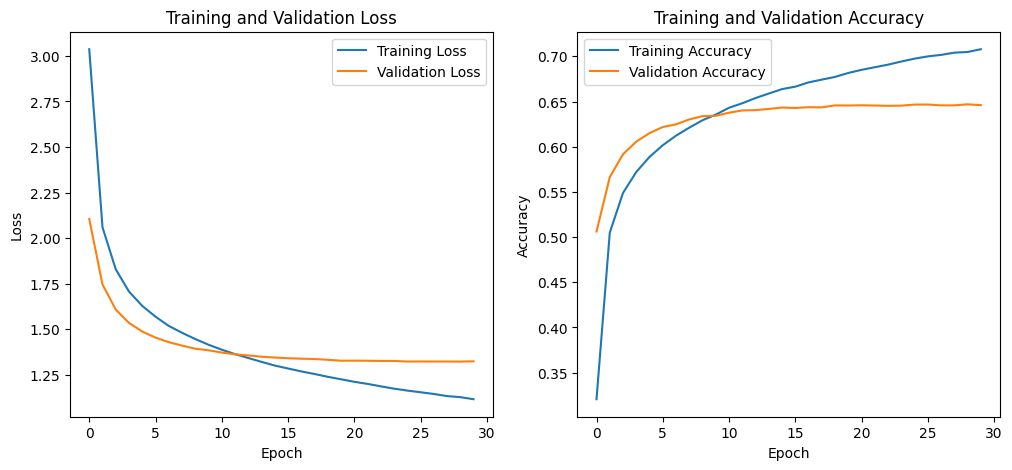

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
model.save('food101_model.h5')
model.save('food101_saved_model.keras')
model.export('food101_saved_model')

Saved artifact at 'food101_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 101), dtype=tf.float32, name=None)
Captures:
  134644426464656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134644426470032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134644426469456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134644426470416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134644426469648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134644426470608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134644426471184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134644426470800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134644426470224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134644426467728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13464

In [24]:
!ls /content/

food101_model.h5  food101_saved_model  food101_saved_model.keras  sample_data


In [25]:
from google.colab import files
files.download('food101_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>